# Data Preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import minimize
from scipy.stats import norm
from scipy.linalg import cho_factor, cho_solve
from sklearn.metrics import mean_squared_error
from tqdm import trange

# Load the Sunspots time series dataset
data = sm.datasets.sunspots.load_pandas().data

# Extract the sunspot counts as a NumPy array
y_full = data["SUNACTIVITY"].values

# Create a time index array corresponding to each observation
t_full = np.arange(len(y_full))

# Define the total number of points to use
n = 200

# Define the size of the training set
train_size = 160

# Truncate the full time and response arrays to the first n points
t = t_full[:n]
y = y_full[:n]

# Split the data into training and testing subsets
t_train = t[:train_size]   # Time indices for training
y_train = y[:train_size]   # Sunspot counts for training
t_test = t[train_size:]    # Time indices for testing
y_test = y[train_size:]    # Sunspot counts for testing

# Print the shapes
print("t_train shape:", t_train.shape)
print("y_train shape:", y_train.shape)
print("t_test shape:", t_test.shape)
print("y_test shape:", y_test.shape)

t_train shape: (160,)
y_train shape: (160,)
t_test shape: (40,)
y_test shape: (40,)


# Base Class

In [2]:
class TimeSeriesModel:
    """Abstract base for time series models."""

    def fit(self, t, y):
        """Estimate parameters from data."""
        raise NotImplementedError

    def predict(self, t):
        """Return in-sample estimates at times t."""
        raise NotImplementedError

    def forecast(self, t_future):
        """Return out-of-sample forecasts at times t_future."""
        raise NotImplementedError

# SSM

In [3]:
def kalman_negloglike(
    params,
    y_series,
):
    """Compute negative log-likelihood for an AR(1) process via the Kalman filter.

    Args:
        params (array-like of length 3):
            phi (float): AR(1) coefficient.
            log_q (float): Log of process (state) noise variance.
            log_r (float): Log of observation noise variance.
        y_series (array-like of length n):
            Time series observations to compute the likelihood over.

    Returns:
        float: Negative log-likelihood value (large penalty if parameters lead to
               numerical issues or non-stationarity).
    """
    # Unpack parameter vector:
    #   phi = AR(1) coefficient, log_q = log process variance, log_r = log observation variance
    phi, log_q, log_r = params

    # Enforce stationarity: if |phi| is too close to 1, return large penalty
    if abs(phi) >= 0.9999:
        return 1e10

    # Convert log-variances back to variances
    q = np.exp(log_q)  # process (state) noise variance
    r = np.exp(log_r)  # observation noise variance

    # Initialize prior state mean m and variance P at stationarity
    m = 0.0
    P = q / (1 - phi**2)

    # Accumulator for the negative log-likelihood
    neg = 0.0

    # Small constant to avoid division by zero
    eps = 1e-8

    # Loop over all observations in the time series
    for i, yi in enumerate(y_series):
        # Innovation (residual) variance S = predicted state variance + observation noise
        S = P + r + eps

        # If S is non-positive or NaN, bail out with large penalty
        if S <= 0 or np.isnan(S):
            return 1e10

        if i == 0:
            # --- Initialization update (no prediction step) ---
            # Compute the likelihood contribution for the first observation:
            #   0.5 * [log(2*pi*S) + yi^2 / S]
            neg += 0.5 * (np.log(2 * np.pi * S) + yi**2 / S)

            # Compute Kalman gain for the update
            K = P / S

            # Update the filtered state estimate and covariance
            m = K * yi
            P = (1 - K) * P
        else:
            # --- Prediction step ---
            # Forecast the next state mean and variance
            m = phi * m
            P = phi**2 * P + q

            # Compute the likelihood contribution for this observation:
            #   0.5 * [log(2*pi*S) + (yi - m)^2 / S]
            neg += 0.5 * (
                np.log(2 * np.pi * S)
                + (yi - m)**2 / S
            )

            # Compute Kalman gain based on predicted uncertainty
            K = P / S

            # Measurement update: refine state estimate and covariance
            m = m + K * (yi - m)
            P = (1 - K) * P

    # Return the total negative log-likelihood
    return neg

def kalman_smoother(
    y_series,
    phi,
    q,
    r,
):
    """Perform Kalman filtering and Rauch–Tung–Striebel smoothing for an AR(1) process.

    Args:
        y_series (array-like of length n): Observed time series values.
        phi (float): AR(1) coefficient.
        q (float): Process (state) noise variance.
        r (float): Observation noise variance.

    Returns:
        ms (np.ndarray of length n): Smoothed state mean estimates.
        m (np.ndarray of length n): Filtered state mean estimates.
    """
    n_pts = len(y_series)

    # Allocate arrays for filtered means and variances
    m = np.zeros(n_pts)        # filtered state mean
    P = np.zeros(n_pts)        # filtered state variance

    # Allocate arrays for one-step-ahead (predicted) means and variances
    m_pred = np.zeros(n_pts)   # predicted state mean
    P_pred = np.zeros(n_pts)   # predicted state variance

    # Initialize at time 0 using stationary distribution
    m[0] = 0.0
    P[0] = q / (1 - phi**2)

    # --- Forward pass: Kalman filter ---
    for i in range(1, n_pts):
        # Time update (prediction):
        m_pred[i] = phi * m[i - 1]
        P_pred[i] = phi**2 * P[i - 1] + q

        # Compute innovation variance: predicted variance + observation noise
        S = P_pred[i] + r

        # Compute Kalman gain
        K = P_pred[i] / S

        # Measurement update:
        m[i] = m_pred[i] + K * (y_series[i] - m_pred[i])
        P[i] = (1 - K) * P_pred[i]

    # --- Backward pass: Rauch–Tung–Striebel smoother ---
    ms = m.copy()  # initialize smoothed means with filtered means

    # Iterate backward from second-last to first time point
    for i in range(n_pts - 2, -1, -1):
        # Smoothing gain
        C = P[i] * phi / P_pred[i + 1]

        # Smoothed state mean
        ms[i] = m[i] + C * (ms[i + 1] - m_pred[i + 1])

    # Return smoothed and filtered state sequences
    return ms, m

In [4]:
class AR1KalmanModel(TimeSeriesModel):
    """AR(1) state-space model fitted via Kalman filtering and smoothing."""

    def fit(self, t, y):
        """
        Estimate AR(1) parameters by maximizing the Kalman filter log-likelihood,
        then run the Kalman smoother to obtain smoothed state estimates.

        Args:
            t (array-like): Time index of observations (not directly used in this model).
            y (array-like): Observed time series values.
        """
        # Center the series around zero to fit zero-mean AR(1)
        y_centered = y - y.mean()

        # Initial guesses for [phi, log(q), log(r)]
        #   phi: AR(1) coefficient (start near 0.8)
        #   log(q): log process variance (start at sample variance)
        #   log(r): log observation variance (start at half sample variance)
        init = np.array([
            0.8,
            np.log(y_centered.var()),
            np.log(0.5 * y_centered.var()),
        ])

        # Bounds on parameters:
        #   phi in (-0.9999, 0.9999) for stationarity
        #   log(q), log(r) unbounded
        bounds = [
            (-0.9999, 0.9999),
            (None, None),
            (None, None),
        ]

        # Define the negative log-likelihood function for optimizer
        def nll(p):
            # p = [phi, log_q, log_r]; y_centered passed to Kalman filter
            return kalman_negloglike(p, y_centered)

        # Run constrained optimization to minimize negative log-likelihood
        res = minimize(
            nll,        # objective
            init,       # initial parameter vector
            bounds=bounds,
        )

        # Extract optimized parameters
        self.phi, log_q, log_r = res.x

        # Transform log-variances back to variances
        self.q = np.exp(log_q)  # process noise variance
        self.r = np.exp(log_r)  # observation noise variance

        # Store the original series mean for de-centering later
        self.y_mean = y.mean()

        # Run the Kalman smoother on the centered data
        #   ms: smoothed state estimates
        #   _m_filt: filtered state estimates (used for forecasting)
        self.ms, self._m_filt = kalman_smoother(
            y_centered,
            self.phi,
            self.q,
            self.r,
        )

    def predict(self, t):
        """
        Return the in-sample smoothed state predictions,
        re-centered by adding back the original mean.

        Args:
            t (array-like): Time index (must align with fit data length).

        Returns:
            array: Smoothed predictions for each time in t.
        """
        # Add back the mean removed during centering
        return self.ms + self.y_mean

    def forecast(self, t_future):
        """
        Generate out-of-sample forecasts for an AR(1) horizon.

        Args:
            t_future (array-like): Future time points (only length is used).

        Returns:
            array: Forecasted values for each future time point.
        """
        horizon = len(t_future)
        forecasts = np.zeros(horizon)

        # Start from the last filtered state estimate
        state = self._m_filt[-1]

        # Recursively propagate the AR(1) state forward
        for k in range(horizon):
            # Forecast next state via AR(1) transition
            state = self.phi * state

            # Re-center by adding the mean of the original series
            forecasts[k] = state + self.y_mean

        return forecasts

# GP

In [5]:
def exp_gp_negloglike(
    params,
    t_arr,
    y_series,
):
    """Return negative log marginal likelihood for an exponential-kernel GP.

    Args:
        params (array-like): Log-hyperparameters [log_l, log_sf, log_sn]
            - log_l: Log length-scale
            - log_sf: Log signal standard deviation
            - log_sn: Log noise standard deviation
        t_arr (array-like): 1D array of input time points
        y_series (array-like): Observed outputs at t_arr
    """
    # Unpack log-transformed hyperparameters
    log_l, log_sf, log_sn = params

    # Convert to actual hyperparameters
    l = np.exp(log_l)             # length-scale for exponential kernel
    sf2 = np.exp(2 * log_sf)      # signal variance = (signal std)^2
    sn2 = np.exp(2 * log_sn)      # noise variance = (noise std)^2

    # Compute pairwise absolute distances between time points
    # D[i, j] = |t_arr[i] - t_arr[j]|
    D = np.abs(np.subtract.outer(t_arr, t_arr))

    # Build the covariance matrix K:
    #   K = sf2 * exp(-D / l) + sn2 * I
    # First term is the exponential kernel; second term adds observational noise on the diagonal
    K = sf2 * np.exp(-D / l) + sn2 * np.eye(len(t_arr))

    # Perform Cholesky factorization for numerical stability:
    #   K = L @ L.T (with L lower-triangular)
    L, lower = cho_factor(K, lower=True)

    # Solve for alpha = K^{-1} y by using the Cholesky factors
    #   alpha = (L L.T)^{-1} y
    alpha = cho_solve((L, lower), y_series)

    # Number of data points
    n = len(t_arr)

    # Compute negative log marginal likelihood:
    #   0.5 * y^T K^{-1} y
    # + sum(log(diag(L)))           [0.5 * log det(K)]
    # + 0.5 * n * log(2*pi)         [normalization constant]
    return (
        0.5 * y_series.dot(alpha)
        + np.sum(np.log(np.diag(L)))
        + 0.5 * n * np.log(2 * np.pi)
    )

In [6]:
class ExpGPModel(TimeSeriesModel):
    """Gaussian process regression with an exponential kernel."""

    def fit(self, t, y):
        """
        Fit the GP hyperparameters by maximizing the log marginal likelihood,
        then precompute quantities for fast predictions.

        Args:
            t (array-like): 1D array of training input time points.
            y (array-like): 1D array of observed outputs at t.
        """
        # Center the outputs to zero mean for numerical stability
        y_centered = y - y.mean()

        # Initial log-hyperparameter guesses: [log(length-scale), log(signal std), log(noise std)]
        init = np.log([10.0, 1.0, 0.5])

        # Define the negative log marginal likelihood function
        def nll(p):
            # p contains [log_l, log_sf, log_sn]
            return exp_gp_negloglike(p, t, y_centered)

        # Optimize hyperparameters without bounds
        res = minimize(
            nll,
            init,
            bounds=[(None, None)] * 3,  # no constraints on log-parameters
        )

        # Extract optimized log-hyperparameters
        log_l, log_sf, log_sn = res.x

        # Convert back to actual kernel parameters
        self.l = np.exp(log_l)           # length-scale
        self.sf2 = np.exp(2 * log_sf)    # signal variance
        self.sn2 = np.exp(2 * log_sn)    # noise variance

        # Store the training set mean for de-centering predictions
        self.y_mean = y.mean()

        # Build the full covariance matrix on training inputs:
        #   K = sf2 * exp(-|t_i - t_j| / l) + sn2 * I
        D = np.abs(np.subtract.outer(t, t))
        K = self.sf2 * np.exp(-D / self.l) + self.sn2 * np.eye(len(t))

        # Perform Cholesky factorization for numerical stability: K = L L^T
        L, lower = cho_factor(K, lower=True)

        # Compute alpha = K^{-1} y_centered via the Cholesky factors
        self._alpha = cho_solve((L, lower), y_centered)

        # Save training inputs for use in forecasting
        self._t_train = t.copy()

    def predict(self, t):
        """
        Compute the GP posterior mean at provided points t (in-sample or new).

        Args:
            t (array-like): 1D array of input points where predictions are required.

        Returns:
            array: Posterior mean values at t, re-centered by adding back y_mean.
        """
        # Compute pairwise distances between prediction points and themselves
        D = np.abs(np.subtract.outer(t, t))

        # Build covariance matrix K_tt for the prediction points
        K = self.sf2 * np.exp(-D / self.l) + self.sn2 * np.eye(len(t))

        # Posterior mean = K_tt @ alpha + y_mean
        return K.dot(self._alpha) + self.y_mean

    def forecast(self, t_future):
        """
        Generate out-of-sample forecasts at future time points based on the trained GP.

        Args:
            t_future (array-like): 1D array of future time points.

        Returns:
            array: Forecasted means at t_future, adding back the training set mean.
        """
        # Compute cross-covariance between future points and training inputs:
        #   [K_*f]_{i,j} = sf2 * exp(-|t_future[i] - t_train[j]| / l)
        D_tf = np.abs(np.subtract.outer(t_future, self._t_train))
        K_tf = self.sf2 * np.exp(-D_tf / self.l)

        # Forecast mean = K_tf @ alpha + y_mean
        return K_tf.dot(self._alpha) + self.y_mean

# Spline

## Naive

In [7]:
class PenalizedSplineModel(TimeSeriesModel):
    """Penalized spline via second-difference penalty."""

    def fit(self, t, y):
        """
        Fit a smoothing spline by minimizing penalized least squares with
        a second-difference penalty on the fitted values.
        """
        # Number of observations
        n = len(y)

        # Center the response around zero for numerical stability
        y_c = y - y.mean()

        # Build the second-difference operator D2 of shape (n-2, n)
        # Each row i encodes f[i-1] - 2 f[i] + f[i+1] = 0
        D2 = np.zeros((n - 2, n))
        for i in range(1, n - 1):
            # Place [1, -2, 1] at columns [i-1, i, i+1]
            D2[i - 1, i - 1:i + 2] = [1, -2, 1]

        # Define a grid of smoothing parameters (lambdas) from 10^-2 to 10^2
        lams = np.logspace(-2, 2, 20)

        # Split indices {0,...,n-1} into 5 folds for cross-validation
        splits = np.array_split(np.arange(n), 5)

        # Store mean squared errors for each lambda
        errs_all = []

        for lam in lams:
            # Collect training errors for each fold
            errs = []

            for idx in splits:
                # Training indices = all indices except those in the current fold
                tr = np.setdiff1d(np.arange(n), idx)

                # Build penalized normal equations: (I + lambda * D2_tr^T * D2_tr) * f_tr = y_c[tr]
                A = np.eye(len(tr)) + lam * (D2[:, tr].T @ D2[:, tr])

                # Solve for the fitted values on the training subset
                f_tr = np.linalg.solve(A, y_c[tr])

                # Compute MSE on the same training subset
                errs.append(np.mean((f_tr - y_c[tr])**2))

            # Average the training errors across folds
            errs_all.append(np.mean(errs))

        # Select lambda that minimizes the cross-validation error
        self.lam = lams[np.argmin(errs_all)]

        # Refit on all data using the chosen lambda
        # Solve (I + lambda * D2^T * D2) * f = y_c for full-length fit
        A_full = np.eye(n) + self.lam * (D2.T @ D2)
        self._fit = np.linalg.solve(A_full, y_c)

        # Store the original mean for de-centering predictions later
        self.y_mean = y.mean()

    def predict(self, t):
        """
        Return in-sample fitted values at times t.
        (Ignores t since fit was on equally spaced indices.)
        """
        # Add back the original mean to the centered fit
        return self._fit + self.y_mean

    def forecast(self, t_future):
        """
        Extrapolate the spline fit into the future by extending the penalty
        operator and solving for new values.
        """
        # Number of fitted (training) points
        n_train = len(self._fit)

        # Total length including future horizon
        n_ext = n_train + len(t_future)

        # Build extended second-difference operator D2_ext (n_ext-2 by n_ext)
        D2_ext = np.zeros((n_ext - 2, n_ext))
        for i in range(1, n_ext - 1):
            D2_ext[i - 1, i - 1:i + 2] = [1, -2, 1]

        # Build extended penalized system: (I + lambda * D2_ext^T * D2_ext) * f_ext = y_ext
        A_ext = np.eye(n_ext) + self.lam * (D2_ext.T @ D2_ext)

        # Create extended response vector: fitted values for training + zeros for future
        y_ext = np.concatenate([self._fit, np.zeros(len(t_future))])

        # Solve for extended fit
        f_ext = np.linalg.solve(A_ext, y_ext)

        # Return only the forecasted portion, re-centered by adding the mean
        return f_ext[n_train:] + self.y_mean

## Exact-Discrete

In [8]:
class PenalizedSplineModel(TimeSeriesModel):
    """Penalized spline via exact-discrete second-difference penalty."""

    def fit(self, t, y):
        """
        Fit a smoothing spline by minimizing
        ||y_c - f||^2 + lambda * Integral ((f''(t))^2 dt),
        using a discrete approximation with boundary constraints.
        """
        # Number of observations
        n = len(y)

        # Grid spacing (assumes equally spaced t)
        dt = float(t[1] - t[0]) if n > 1 else 1.0

        # Center for numerical stability
        y_c = y - y.mean()

        # Build discrete second-difference operator on interior points
        D_int = np.zeros((n - 2, n))
        for i in range(1, n - 1):
            D_int[i - 1, i - 1 : i + 2] = [1, -2, 1]

        # Scale to approximate f'' as (Delta^2 f)/(Delta t^2)
        D_int /= dt**2

        # Add two boundary rows to enforce natural BC: f''(t0)=f''(tn)=0
        D_bc = np.zeros((2, n))
        D_bc[0, 0:3] = [1, -2, 1]
        D_bc[1, -3:] = [1, -2, 1]
        D_bc /= dt**2

        # Full penalty operator
        D_full = np.vstack([D_bc, D_int])

        # Cross-validate lambda
        lams = np.logspace(-2, 2, 20)
        idxs = np.arange(n)
        splits = np.array_split(idxs, 5)
        errs_all = []

        for lam in lams:
            errs = []

            # Penalty term: Sum (D_full f)^2 * Delta t
            P_factor = lam * dt
            for test_idx in splits:
                train_idx = np.setdiff1d(idxs, test_idx)

                # Form penalized normal equations on training subset
                D_tr = D_full[:, train_idx]
                A = (np.eye(train_idx.size)
                     + P_factor * (D_tr.T @ D_tr))
                f_tr = np.linalg.solve(A, y_c[train_idx])
                errs.append(np.mean((f_tr - y_c[train_idx])**2))
            errs_all.append(np.mean(errs))

        # Pick best lambda
        self.lam = lams[np.argmin(errs_all)]
        P_factor = self.lam * dt

        # Final fit on all data
        A_full = np.eye(n) + P_factor * (D_full.T @ D_full)
        self._fit = np.linalg.solve(A_full, y_c)
        self.y_mean = y.mean()

    def predict(self, t):
        """
        Return in-sample fitted values at times t.
        (Ignores t since fit was on equally spaced indices.)
        """
        # In-sample: ignore t (uniform grid assumed)
        return self._fit + self.y_mean

    def forecast(self, t_future):
        """
        Extrapolate the spline fit into the future by extending the penalty
        operator and solving for new values.
        """
        # Extrapolate by re-building D_full on the extended grid
        n_train = len(self._fit)
        dt = 1.0  # same spacing assumed
        n_ext = n_train + len(t_future)

        # Interior
        D_int = np.zeros((n_ext - 2, n_ext))
        for i in range(1, n_ext - 1):
            D_int[i - 1, i - 1 : i + 2] = [1, -2, 1]
        D_int /= dt**2

        # Boundary
        D_bc = np.zeros((2, n_ext))
        D_bc[0, 0:3] = [1, -2, 1]
        D_bc[1, -3:] = [1, -2, 1]
        D_bc /= dt**2

        D_full = np.vstack([D_bc, D_int])
        P_factor = self.lam * dt

        A_ext = np.eye(n_ext) + P_factor * (D_full.T @ D_full)
        y_ext = np.concatenate([self._fit, np.zeros(len(t_future))])
        f_ext = np.linalg.solve(A_ext, y_ext)

        return f_ext[n_train:] + self.y_mean

# BNN

In [9]:
def init_bnn_params(H, rng, y_centered):
    """
    Initialize parameters for a one-hidden-layer Bayesian neural network.

    theta layout (total length = 3H + 2):
      - w: weights from input to hidden layer, shape (H, 1)
      - b: biases for hidden units, shape (H,)
      - u: weights from hidden to output, shape (1, H)
      - log_sigma_w: log of hidden-layer weight prior std
      - log_sigma_n: log of output noise std

    Args:
        H (int): Number of hidden units.
        rng (Generator): NumPy random number generator.
        y_centered (array): Centered target values for initial noise scaling.

    Returns:
        np.ndarray: Initial theta vector.
    """
    # Total number of weight parameters (input -> hidden, hidden biases, hidden -> output)
    D_w = 3 * H

    # Sample base parameters from standard normal
    base = rng.normal(scale=1.0, size=D_w)

    # Append initial log_sigma_w = 0 and log_sigma_n based on data variance
    #   log_sigma_n = log(0.1 * var(y_centered))
    return np.concatenate([
        base,
        [0.0, np.log(np.var(y_centered) * 0.1)]
    ])

def unpack_params(theta, H):
    """
    Split theta into individual components.

    Args:
        theta (array): Parameter vector of length 3H + 2.
        H (int): Number of hidden units.

    Returns:
        w (array): Input -> hidden weights, shape (H, 1).
        b (array): Hidden biases, shape (H,).
        u (array): Hidden -> output weights, shape (1, H).
        log_sw (float): Log prior std of network weights.
        log_sn (float): Log std of output noise.
    """
    # First H entries -> w_i for each hidden unit
    w = theta[0:H].reshape(H, 1)

    # Next H entries -> b_i
    b = theta[H:2 * H]

    # Next H entries -> u_j
    u = theta[2 * H:3 * H].reshape(1, H)

    # Final two entries -> log_sigma_w, log_sigma_n
    log_sw = theta[3 * H]
    log_sn = theta[3 * H + 1]
    return w, b, u, log_sw, log_sn

def bnn_forward(x, theta, H):
    """
    Compute the neural network output f(x; theta) for scalar inputs x.

    Architecture: scalar input -> H ReLU hidden units -> scalar output.

    Args:
        x (array): 1D array of input features.
        theta (array): Parameter vector.
        H (int): Number of hidden units.

    Returns:
        array: Predicted outputs, same length as x.
    """
    # Unpack network parameters
    w, b, u, _, _ = unpack_params(theta, H)

    # Linear transform to hidden layer: Z[i, j] = x[i] * w[j] + b[j]
    Z = x.reshape(-1, 1) @ w.T + b

    # Apply ReLU activation elementwise
    H_act = np.maximum(0, Z)

    # Compute output: f = H_act @ u^T, then flatten to 1D
    return (H_act @ u.T).ravel()

def log_prior(theta, H):
    """
    Compute log prior density for theta.

    Prior on weight vector w_vec ~ N(0, sigma_w^2), where sigma_w = exp(log_sw).
    Priors on log hyperparameters ~ N(0, 1).

    Args:
        theta (array): Parameter vector.
        H (int): Number of hidden units.

    Returns:
        float: Sum of log-prior contributions.
    """
    # Collect all weight parameters (first 3H entries)
    wvec = theta[:3 * H]
    _, _, _, log_sw, log_sn = unpack_params(theta, H)

    # Convert log_std to std
    sigma_w = np.exp(log_sw)

    # Log-density of weights under N(0, sigma_w^2)
    lp_w = np.sum(norm.logpdf(wvec, loc=0.0, scale=sigma_w))

    # Log-density of log_sw and log_sn under standard normal
    lp_sw = norm.logpdf(log_sw, loc=0.0, scale=1.0)
    lp_sn = norm.logpdf(log_sn, loc=0.0, scale=1.0)

    return lp_w + lp_sw + lp_sn

def log_likelihood(theta, x, y, H):
    """
    Compute log likelihood log p(y | theta, x).

    Observation model: y_i ~ N(f(x_i; theta), sigma_n^2), with sigma_n = exp(log_sn).

    Args:
        theta (array): Parameter vector.
        x (array): Input array.
        y (array): Centered target array.
        H (int): Number of hidden units.

    Returns:
        float: Sum of log-likelihood over data points.
    """
    _, _, _, _, log_sn = unpack_params(theta, H)
    sigma_n = np.exp(log_sn)

    # Compute network predictions
    f = bnn_forward(x, theta, H)

    # Sum log-density of y under N(f, sigma_n^2)
    return np.sum(norm.logpdf(y, loc=f, scale=sigma_n))

def log_posterior(theta, x, y, H):
    """
    Compute the unnormalized log-posterior: log prior + log likelihood.

    Args:
        theta (array): Parameter vector.
        x (array): Input array.
        y (array): Centered target array.
        H (int): Number of hidden units.

    Returns:
        float: Unnormalized log-posterior value.
    """
    return log_prior(theta, H) + log_likelihood(theta, x, y, H)

def metropolis_hastings(
    x,
    y,
    H,
    n_samples=1000,
    burn_in=500,
    thinning=10,
    step_size=0.02,
    seed=0,
):
    """
    Perform Metropolis-Hastings sampling for BNN parameters theta.

    Args:
        x (array): Input data.
        y (array): Observed outputs.
        H (int): Number of hidden units.
        n_samples (int): Number of retained samples after burn-in and thinning.
        burn_in (int): Number of initial iterations to discard.
        thinning (int): Interval between retained samples.
        step_size (float): Std of Gaussian proposal perturbations.
        seed (int): RNG seed for reproducibility.

    Returns:
        array: Samples of theta, shape (n_samples, len(theta)).
    """
    rng = np.random.default_rng(seed)

    # Center outputs to zero mean for noise initialization
    y_centered = y - y.mean()

    # Initialize theta from prior-informed heuristic
    theta = init_bnn_params(H, rng, y_centered)

    # Compute initial log-posterior
    lp_cur = log_posterior(theta, x, y_centered, H)

    D = theta.size
    samples = []

    # Total iterations including burn-in
    total = n_samples * thinning + burn_in

    # Run the MH chain with a progress bar
    for i in trange(total, desc="MH BNN sampling"):
        # Propose new theta by Gaussian perturbation
        prop = theta + rng.normal(scale=step_size, size=D)

        # Compute log-posterior at proposed theta
        lp_prop = log_posterior(prop, x, y_centered, H)

        # Accept-reject step: accept with probability min(1, exp(lp_prop - lp_cur))
        if np.log(rng.random()) < (lp_prop - lp_cur):
            theta, lp_cur = prop, lp_prop

        # After burn-in, record every 'thinning' steps
        if i >= burn_in and (i - burn_in) % thinning == 0:
            samples.append(theta.copy())

    return np.array(samples)

In [10]:
class WideBNNModel(TimeSeriesModel):
    """One-hidden-layer ReLU Bayesian neural network using Metropolis–Hastings sampling."""

    def __init__(
        self,
        H=5000,
        n_samples=1000,
        burn_in=500,
        thinning=10,
        step_size=0.02,
        seed=0,
    ):
        """
        Initialize BNN sampling and architecture parameters.

        Args:
            H (int): Number of hidden ReLU units.
            n_samples (int): Number of MCMC samples to retain.
            burn_in (int): Number of initial MCMC iterations to discard.
            thinning (int): Interval between retained samples.
            step_size (float): Proposal std for Metropolis–Hastings moves.
            seed (int): RNG seed for reproducibility.
        """
        # Hidden layer width
        self.H = H

        # MCMC sampling parameters
        self.n_samples = n_samples
        self.burn_in = burn_in
        self.thinning = thinning
        self.step_size = step_size
        self.seed = seed

    def fit(self, t, y):
        """
        Fit the BNN by drawing posterior samples for the network weights.

        Args:
            t (array): Input time points (treated as scalar features).
            y (array): Observed outputs at times t.
        """
        # Store the sample mean of y for later de-centering of predictions
        self.y_mean = y.mean()

        # Run Metropolis–Hastings to obtain samples of theta in the centered output space
        # theta includes input -> hidden weights, biases, output weights, and log-noise scales
        self.theta_samples = metropolis_hastings(
            x=t,
            y=y,
            H=self.H,
            n_samples=self.n_samples,
            burn_in=self.burn_in,
            thinning=self.thinning,
            step_size=self.step_size,
            seed=self.seed,
        )

        # Save training inputs for prediction context
        self.t_train = t.copy()

    def predict(self, t):
        """
        Compute the posterior mean prediction at inputs t.

        Args:
            t (array): Input points for which to compute the BNN posterior mean.

        Returns:
            array: Posterior mean predictions, re-centered by adding y_mean.
        """
        preds = []

        # For each sampled parameter vector, compute the network output
        for theta in self.theta_samples:
            preds.append(bnn_forward(t, theta, self.H))

        # Average the predicted functions across all posterior samples
        f_mean = np.mean(preds, axis=0)

        # Add back the original mean removed during fitting
        return f_mean + self.y_mean

    def forecast(self, t_future):
        """
        Forecast future outputs at new inputs.

        Since this BNN has no explicit temporal dynamics beyond using t as features,
        forecasting is identical to posterior prediction at arbitrary new t values.

        Args:
            t_future (array): Future input points.

        Returns:
            array: Posterior mean predictions at t_future.
        """
        return self.predict(t_future)

# KBLR

In [11]:
def kblr_negloglike(
    params,
    t_arr,
    y_arr,
):
    """Compute negative log marginal likelihood for kernelized Bayesian linear regression
    with an exponential kernel.

    Args:
        params (array-like): Log-hyperparameters [log_l, log_sf, log_sn]
            - log_l: Log length-scale of the exponential kernel
            - log_sf: Log signal standard deviation
            - log_sn: Log noise standard deviation
        t_arr (array-like): 1D array of input points (e.g., time indices)
        y_arr (array-like): 1D array of observed responses at t_arr

    Returns:
        float: Negative log marginal likelihood value
    """
    # Unpack the log-hyperparameters
    log_l, log_sf, log_sn = params

    # Convert to actual hyperparameters
    l_val = np.exp(log_l)          # length-scale for kernel: controls smoothness
    sf2 = np.exp(2 * log_sf)       # signal variance = (signal std)^2
    sn2 = np.exp(2 * log_sn)       # noise variance = (noise std)^2

    # Compute pairwise absolute distances between input points
    # D[i, j] = |t_arr[i] - t_arr[j]|
    D = np.abs(np.subtract.outer(t_arr, t_arr))

    # Build the kernel matrix K using the exponential kernel:
    # K[i, j] = sf2 * exp(-D[i, j] / l_val)
    K = sf2 * np.exp(-D / l_val)

    # Add observational noise variance on the diagonal:
    # C = K + sn2 * I
    C = K + sn2 * np.eye(len(t_arr))

    # Perform Cholesky factorization for numerical stability:
    # C = L @ L.T, where L is lower-triangular
    L, lower = cho_factor(C, lower=True)

    # Solve for alpha = C^{-1} y_arr using the cached Cholesky factors
    alpha = cho_solve((L, lower), y_arr)

    # Number of data points
    n = len(t_arr)

    # Compute the negative log marginal likelihood:
    # 0.5 * y^T C^{-1} y          data fit term
    # + sum(log(diag(L)))         0.5 * log|C|  (log-determinant)
    # + 0.5 * n * log(2*pi)       normalization constant
    neg_log_marginal = (
        0.5 * y_arr.dot(alpha)
        + np.sum(np.log(np.diag(L)))
        + 0.5 * n * np.log(2 * np.pi)
    )

    return neg_log_marginal

In [12]:
class KBLRModel(TimeSeriesModel):
    """Kernelized Bayesian linear regression in the weight-space view.

    This model learns an exponential kernel on the inputs, computes the
    posterior over weight-space coefficients (alpha), and then uses those
    coefficients for in-sample prediction and out-of-sample forecasting.
    """

    def __init__(
        self,
        n_draws=1000,
        seed=0,
    ):
        """
        Initialize the KBLR model.

        Args:
            n_draws (int): Number of posterior-weight (alpha) samples to draw
                           for constructing forecast distributions.
            seed (int): Seed for NumPy's RNG to ensure reproducibility.
        """
        # Number of Monte Carlo draws for weight-space sampling
        self.n_draws = n_draws

        # Seed the global RNG for consistent parameter sampling
        np.random.seed(seed)

    def fit(self, t, y):
        """
        Fit the KBLR model to the training data.

        Steps:
          1. Center the outputs y to zero mean for numerical stability.
          2. Optimize kernel hyperparameters by minimizing the negative
             log marginal likelihood.
          3. Build the training kernel matrix K and add noise variance
             to form C = K + sigma_n^2 I.
          4. Compute the posterior mean (alpha_mean) and covariance
             (alpha_cov) of the weight-space coefficients.
          5. Draw Monte Carlo samples of alpha ~ N(alpha_mean, alpha_cov).

        Args:
            t (array-like): 1D array of training input points.
            y (array-like): 1D array of responses at t.
        """
        # Store original mean of y for de-centering predictions later
        self.y_mean = y.mean()

        # Centered outputs
        y_c = y - self.y_mean

        # Wrapper for negative log marginal likelihood of the kernel model
        def nle(params):
            # params = [log_length_scale, log_signal_std, log_noise_std]
            return kblr_negloglike(params, t, y_c)

        # Initial log-hyperparameter guesses:
        #   length-scale=5.0, signal-std=1.0, noise-std=0.5
        init = np.log([5.0, 1.0, 0.5])

        # Unconstrained optimization over log-parameters
        res = minimize(
            nle,
            init,
            bounds=[(None, None)] * 3,  # no bounds on log hyperparams
        )

        # Extract optimized log-hyperparameters
        log_l, log_sf, log_sn = res.x

        # Convert logs back to actual kernel parameters
        self.l_val = np.exp(log_l)         # length-scale
        self.sf2 = np.exp(2 * log_sf)      # signal variance = (signal std)^2
        self.sn2 = np.exp(2 * log_sn)      # noise variance = (noise std)^2

        # Build the n×n training kernel matrix:
        #   K_ij = sf2 * exp(-|t[i] - t[j]| / l_val)
        D = np.abs(np.subtract.outer(t, t))
        K = self.sf2 * np.exp(-D / self.l_val)

        # Add observation noise variance on the diagonal: C = K + sn2 * I
        C = K + self.sn2 * np.eye(len(t))

        # Cholesky factorization of C for efficient linear solves:
        #   C = L @ L.T, with L lower-triangular
        L_low = cho_factor(C, lower=True)

        # Compute posterior mean of alpha: alpha_mean = C^{-1} y_c
        self.alpha_mean = cho_solve(L_low, y_c)

        # Compute C^{-1} for covariance construction
        Cinv = cho_solve(L_low, np.eye(len(t)))

        # Posterior covariance of alpha: sigma_n^2 * C^{-1}
        self.alpha_cov = self.sn2 * Cinv

        # Draw Monte Carlo samples of alpha from N(alpha_mean, alpha_cov)
        #   Resulting shape before transpose: (n_draws, n_train)
        #   After transpose: (n_train, n_draws) for easier dot-products
        self.alpha_samples = np.random.multivariate_normal(
            self.alpha_mean,
            self.alpha_cov,
            size=self.n_draws,
        ).T

        # Store training inputs and kernel matrix for prediction
        self.t_train = t.copy()
        self.K_train = K

    def predict(self, t):
        """
        Compute the posterior-mean in-sample predictions.

        Args:
            t (array-like): Should match training inputs used in fit.

        Returns:
            array: Fitted values y_hat = K_train @ alpha_mean + y_mean.
        """
        # In-sample prediction uses the precomputed K_train matrix
        return self.K_train.dot(self.alpha_mean) + self.y_mean

    def forecast(self, t_future):
        """
        Generate weight-space sampled forecasts and return their mean.

        Steps:
          1. Compute cross-kernel K_tf between future inputs and training inputs.
          2. Multiply by each alpha_samples draw to get forecast draws.
          3. Average across draws to obtain predictive mean.
          4. Add back the original y_mean for de-centering.

        Args:
            t_future (array-like): New input points for forecasting.

        Returns:
            array: Posterior predictive mean at t_future.
        """
        # Cross-distance matrix between future and train: shape (n_future, n_train)
        D_tf = np.abs(np.subtract.outer(t_future, self.t_train))

        # Cross-kernel: K_tf[i,j] = sf2 * exp(-|t_future[i] - t_train[j]| / l_val)
        K_tf = self.sf2 * np.exp(-D_tf / self.l_val)

        # Multiply cross-kernel by weight draws to get forecast draws:
        #   f_draws shape: (n_future, n_draws)
        f_draws = K_tf.dot(self.alpha_samples)

        # Posterior predictive mean across draws
        f_mean = f_draws.mean(axis=1)

        # Return de-centered forecasts
        return f_mean + self.y_mean

# Instantiate & Fit

In [13]:
# Instantiate and fit models
models = {
    "SSM": AR1KalmanModel(),
    "GP": ExpGPModel(),
    "Spline": PenalizedSplineModel(),
    "BNN": WideBNNModel(H=6000),
    "KBLR": KBLRModel(),
}

for name, model in models.items():
    model.fit(t_train, y_train)

MH BNN sampling: 100%|██████████| 10500/10500 [03:43<00:00, 47.08it/s]


# Forecasting

In [14]:
# Produce predictions and forecasts
trains = {
    name: model.predict(t_train)
    for name, model in models.items()
}

forecasts = {
    name: model.forecast(t_test)
    for name, model in models.items()
}

# Evaluation

In [15]:
# Build a DataFrame of results
df_results = pd.DataFrame({
    'TrainRMSE': [
        np.sqrt(mean_squared_error(y_train, trains[name]))
        for name in models
    ],
    'TestRMSE': [
        np.sqrt(mean_squared_error(y_test, forecasts[name]))
        for name in models
    ]
}, index=models)

df_results.index.name = 'Model'

# Display the DataFrame
display(df_results.round(3))

,TrainRMSE,TestRMSE
Model,,
SSM,5.725,31.684
GP,0.000,31.819
Spline,0.413,32.781
BNN,34.671,32.730
KBLR,0.000,31.819


# Visualization

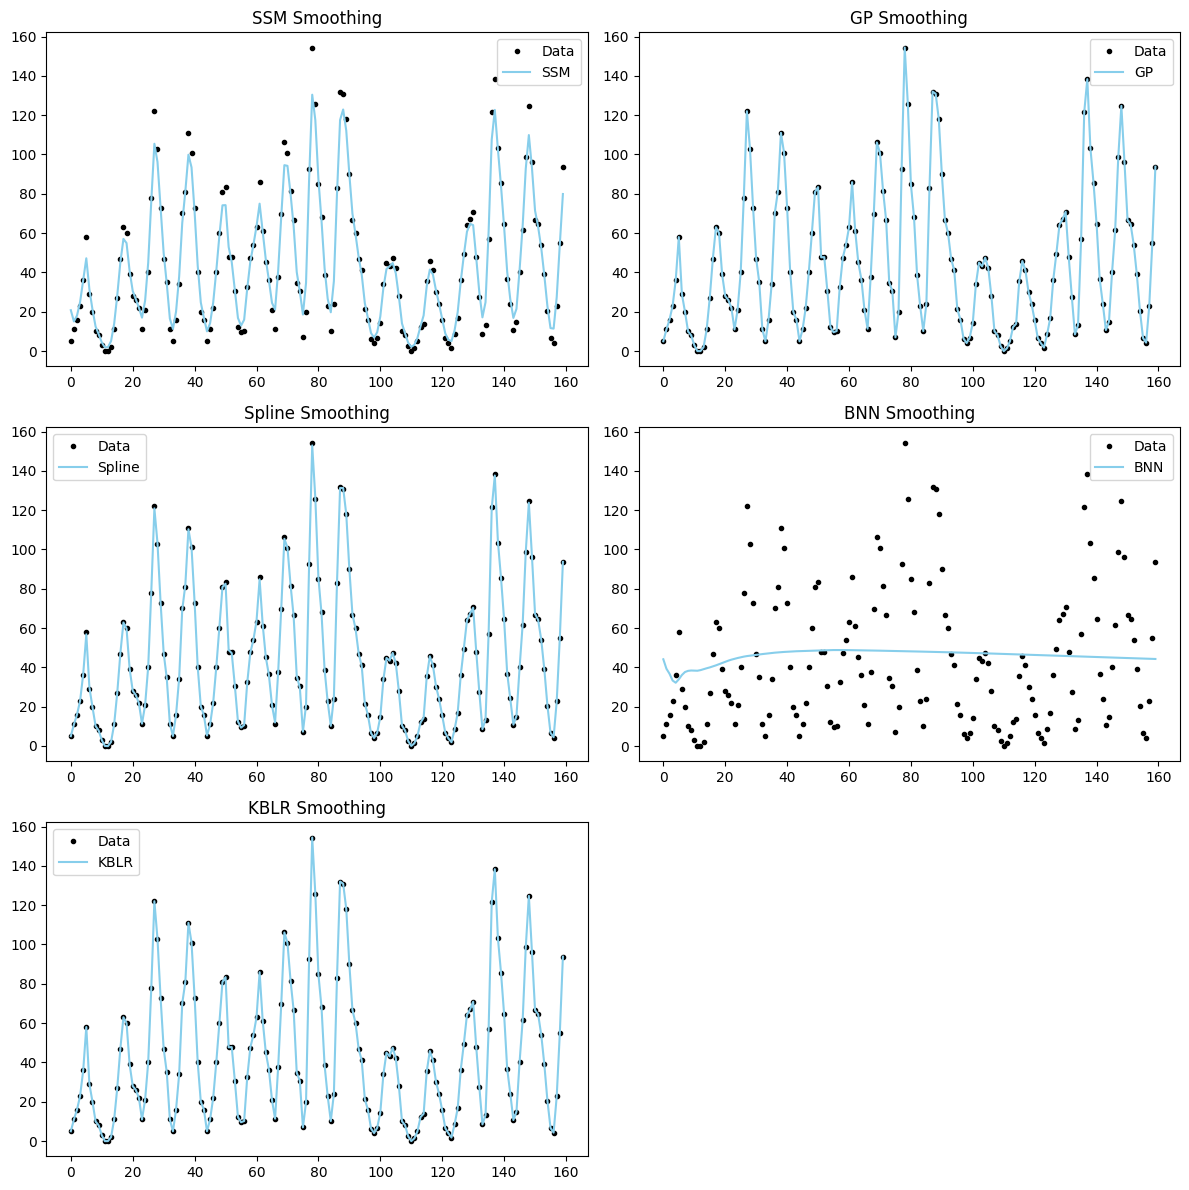

In [16]:
# Plot smoothing curves
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for idx, (name, yhat) in enumerate(trains.items()):
    ax = axes.flatten()[idx]
    ax.plot(t_train, y_train, "k.", label="Data")
    ax.plot(t_train, yhat, "skyblue", label=name)
    ax.set_title(f"{name} Smoothing")
    ax.legend()
axes.flatten()[5].axis("off")
plt.tight_layout()
plt.show()

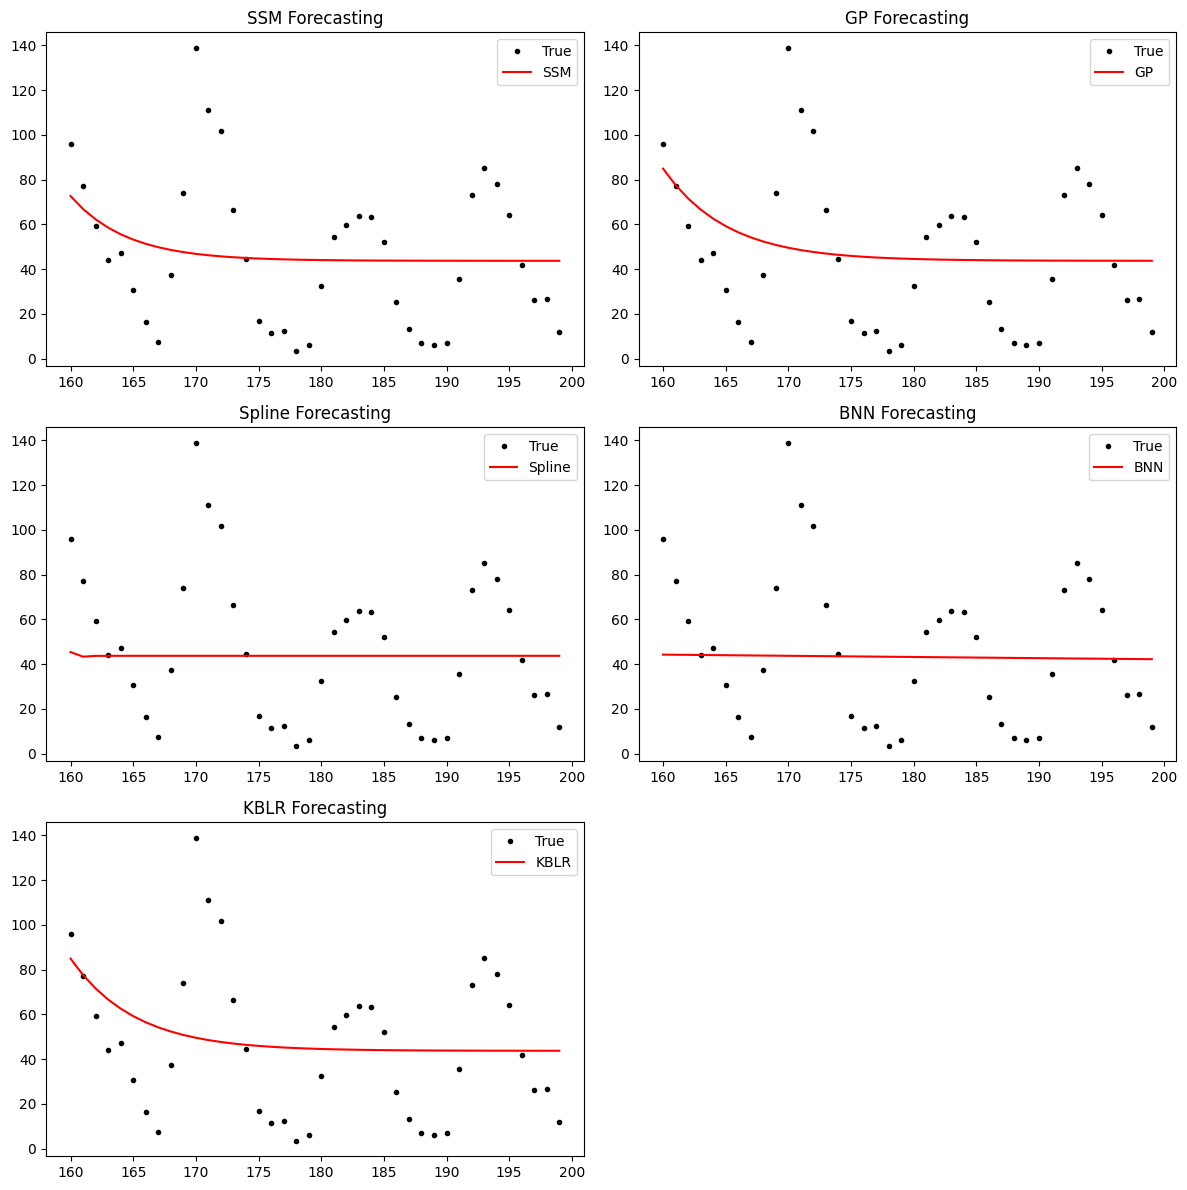

In [17]:
# Plot forecasts
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
for idx, (name, yf) in enumerate(forecasts.items()):
    ax = axes.flatten()[idx]
    ax.plot(t_test, y_test, "k.", label="True")
    ax.plot(t_test, yf, "red", label=name)
    ax.set_title(f"{name} Forecasting")
    ax.legend()
axes.flatten()[5].axis("off")
plt.tight_layout()
plt.show()